# Implementation of Retrieval of Tropospheric Water Vapor Scale Height from Horizontal Turbulence Structure

In [9]:
from download_gmi_data import get_gmi_data
import os
import sys
import pickle
import numpy as np
from gmi_daily_v8 import GMIdaily
from gmi_averaged_v8 import GMIaveraged
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Getting Data From Remote Sensing Systems Website

In [2]:
folder_name = ''
files = [f for f in os.listdir(folder_name+'daily_data/') if 'f35' in f]

In [3]:
def read_data(folder_name=folder_name+'daily_data', file_name='f35_20231001v8.2_d3d.gz'):
    file_path = '/'.join([folder_name, file_name])
    avg = False
    if 'd3d' in file_name:
        dataset = GMIaveraged(file_path, missing=np.nan)
        avg = True
    else:
        dataset = GMIdaily(file_path, missing=np.nan)
    if not dataset.variables: sys.exit('problem reading file')
    return (avg, dataset)

# Define lat and lon of location of interest

In [4]:
lat_deg_to_idx = lambda x: int((x + 90)*4)
lon_deg_to_idx = lambda x: int(x*4)
lat_idx_to_deg = lambda x: x//4 - 90
lon_idx_to_deg = lambda x: x//4

# Hawaii
radiosonde_latlon = (22, 200)
radiosonde_ilatilon = (lat_deg_to_idx(radiosonde_latlon[0]), lon_deg_to_idx(radiosonde_latlon[1]))

buffer = 10
ilat_min = lat_deg_to_idx(radiosonde_latlon[0]-buffer)
ilon_min = lon_deg_to_idx(radiosonde_latlon[1]-buffer)
ilat_max = lat_deg_to_idx(radiosonde_latlon[0]+buffer)
ilon_max = lon_deg_to_idx(radiosonde_latlon[1]+buffer)

# Run Turbulence Structure Estimator 

In [65]:
%%time

from turbulence_structure_estimator import TurbulenceStructureEstimator
import numpy as np
import re
from datetime import datetime, timedelta

time_betahat_dict = {}
for f in files:
    date = re.search(r'f35_(\d{4})(\d{2})(\d{2})v8\.2\.gz', f)
    yyyy, mm, dd = date.group(1), date.group(2), date.group(3)
    gmt_midnight = datetime(int(yyyy), int(mm), int(dd))

    avged, dataset = read_data(file_name=f)
    tse_asc = TurbulenceStructureEstimator(dataset.variables['vapor'][0, :, :], 2, \
                                    ilat_min=ilat_min, ilon_min=ilon_min, \
                                    ilat_max=ilat_max, ilon_max=ilon_max,
                                    verbose=False)
    tse_desc = TurbulenceStructureEstimator(dataset.variables['vapor'][1, :, :], 2, \
                                    ilat_min=ilat_min, ilon_min=ilon_min, \
                                    ilat_max=ilat_max, ilon_max=ilon_max,
                                    verbose=False)
    ilatilon_betaciwv_dict_asc = tse_asc.run_algorithm()
    ilatilon_betaciwv_dict_desc = tse_desc.run_algorithm()

    beta_asc = ilatilon_betaciwv_dict_asc[radiosonde_ilatilon[0], radiosonde_ilatilon[1]][0]
    beta_desc = ilatilon_betaciwv_dict_desc[radiosonde_ilatilon[0], radiosonde_ilatilon[1]][0]

    if not np.isnan(beta_asc):
        time_asc = float(np.nanmean(dataset.variables['time'][0, \
                                radiosonde_ilatilon[0]-buffer:radiosonde_ilatilon[0]+buffer, \
                                radiosonde_ilatilon[1]-buffer:radiosonde_ilatilon[1]+buffer].flatten()))
        time_delta = timedelta(hours=float(time_asc))
        desired_datetime = gmt_midnight + time_delta
        time_betahat_dict[desired_datetime] = beta_asc

    if not np.isnan(beta_desc):
        time_desc = float(np.nanmean(dataset.variables['time'][1, \
                                radiosonde_ilatilon[0]-buffer:radiosonde_ilatilon[0]+buffer, \
                                radiosonde_ilatilon[1]-buffer:radiosonde_ilatilon[1]+buffer].flatten()))
        time_delta = timedelta(hours=float(time_desc))
        desired_datetime = gmt_midnight + time_delta
        time_betahat_dict[desired_datetime] = beta_desc



Wall time: 9min 19s


# Save or Open Time vs Beta Dictionary

In [5]:
# with open('time_betahat_dict.pkl', 'wb') as file:
#     pickle.dump(time_betahat_dict, file)
with open('time_betahat_dict.pkl', 'rb') as file:
    time_betahat_dict = pickle.load(file)

# Plot Time vs Betas

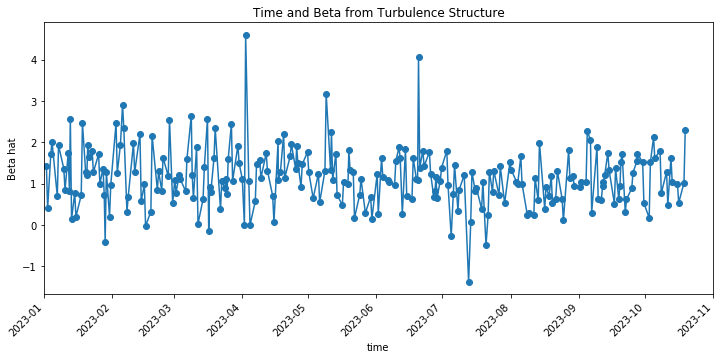

In [6]:
times = sorted(time_betahat_dict.keys())
values = [time_betahat_dict[key] for key in times]

figure_size = (12,5)
plt.figure(figsize=figure_size)
plt.plot(times, values, 'o-')
plt.xticks(rotation=45, ha='right')
plt.xlim([datetime(2023, 1, 1, 0, 0, 0), datetime(2023, 11, 1, 0, 0, 0)])
plt.title('Time and Beta from Turbulence Structure')
plt.xlabel('time')
plt.ylabel('Beta hat')
plt.show()

# Get estimated PBL Heights

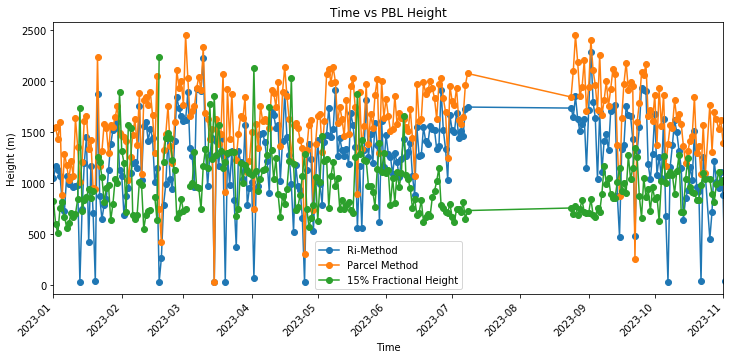

In [7]:
with open('pbl_height_ri_dict.pkl', 'rb') as file:
    pbl_height_ri_dict = pickle.load(file)
with open('pbl_height_holzworth_dict.pkl', 'rb') as file:
    pbl_height_holzworth_dict = pickle.load(file)
with open('frac_height_15_dict.pkl', 'rb') as file:
    frac_height_15_dict = pickle.load(file)
    
dates_00 = [k for k in pbl_height_ri_dict.keys() if k.hour == 0]
ris = [pbl_height_ri_dict[k] for k in dates_00]
holzs = [pbl_height_holzworth_dict[k] for k in dates_00]
frac_heights = [frac_height_15_dict[k] for k in dates_00]

figure_size = (12,5)
plt.figure(figsize=figure_size)
plt.plot(dates_00, ris, 'o-')
plt.plot(dates_00, holzs, 'o-')
plt.plot(dates_00, frac_heights, 'o-')
plt.xticks(rotation=45, ha='right')
plt.xlim([datetime(2023, 1, 1, 0, 0, 0), datetime(2023, 11, 1, 0, 0, 0)])
plt.title('Time vs PBL Height')
plt.xlabel('Time')
plt.ylabel('Height (m)')
plt.legend(['Ri-Method', 'Parcel Method', '15% Fractional Height'])
plt.show()

# Intercompare Betas with Radiosonde Heights

In [24]:
def get_radiosonde_betas(time_radiosonde_dict, time_betahat_dict, max_timedelta_sec = timedelta(minutes=200), gmt=0):
    times_beta = sorted(time_betahat_dict.keys())
    times_radiosonde = sorted(time_radiosonde_dict.keys())

    heights = []
    betas = []
    for t in times_beta:
        radiosonde_dt = None
        if gmt == 12:
            radiosonde_noon = datetime(t.year, t.month, t.day, 12)
            if abs(t-radiosonde_noon) < max_timedelta_sec:
                radiosonde_dt = radiosonde_noon
        elif gmt == 0:
            radiosonde_midnight = datetime(t.year, t.month, t.day, 0)
            radiosonde_midnight1 = datetime(t.year, t.month, t.day, 0)+timedelta(days=1)

            if abs(t-radiosonde_midnight) < max_timedelta_sec:
                radiosonde_dt = radiosonde_midnight
            elif abs(t-radiosonde_midnight1) < max_timedelta_sec:
                radiosonde_dt = radiosonde_midnight1

        if radiosonde_dt != None and radiosonde_dt in times_radiosonde:
            heights.append(time_radiosonde_dict[radiosonde_dt])
            betas.append(time_betahat_dict[t])
    return (heights, betas)

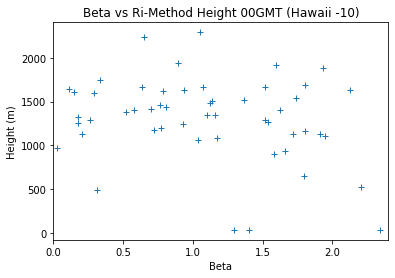

r= -0.27


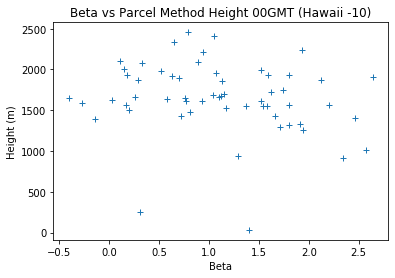

r= -0.18


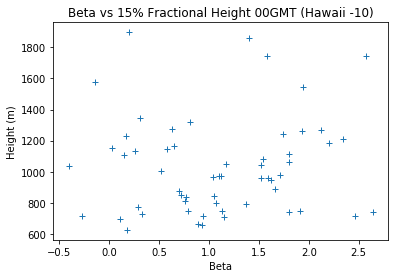

r= nan


In [25]:
pbl_heights_ri, turbulence_exponents_ri = get_radiosonde_betas(pbl_height_ri_dict, time_betahat_dict, gmt=0)

plt.figure()
plt.plot(turbulence_exponents_ri, pbl_heights_ri, '+')
plt.xlim([0, 2.4])
# plt.ylim([32000, 38000])
plt.title('Beta vs Ri-Method Height 00GMT (Hawaii -10)')
plt.xlabel('Beta')
plt.ylabel('Height (m)')
plt.show()
print('r=', round(np.corrcoef(turbulence_exponents_ri, pbl_heights_ri)[0,1],2))

pbl_heights_holz, turbulence_exponents_holz = get_radiosonde_betas(pbl_height_holzworth_dict, time_betahat_dict, gmt=0)

plt.figure()
plt.plot(turbulence_exponents_holz, pbl_heights_holz, '+')
# plt.xlim([0, 2.4])
# plt.ylim([500, 2200])
plt.title('Beta vs Parcel Method Height 00GMT (Hawaii -10)')
plt.xlabel('Beta')
plt.ylabel('Height (m)')
plt.show()
print('r=', round(np.corrcoef(turbulence_exponents_holz, pbl_heights_holz)[0,1],2))

# for key in frac_height_15_dict.keys():
#     if frac_height_15_dict[key] == None:
#         print('hi')
#         frac_height_15_dict[key] = np.nan
frac_heights, turbulence_exponents_hfs = get_radiosonde_betas(frac_height_15_dict, time_betahat_dict, gmt=0)

plt.figure()
plt.plot(turbulence_exponents_hfs, frac_heights, '+')
# plt.xlim([0, 2.4])
# plt.ylim([500, 2200])
plt.title('Beta vs 15% Fractional Height 00GMT (Hawaii -10)')
plt.xlabel('Beta')
plt.ylabel('Height (m)')
plt.show()
print('r=', np.corrcoef(turbulence_exponents_hfs, frac_heights)[0,1])


r= -0.25


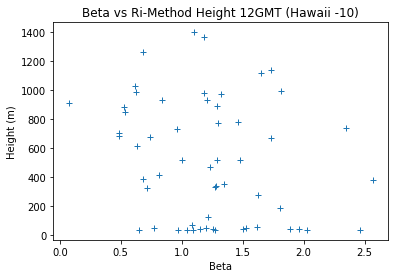

r= -0.28


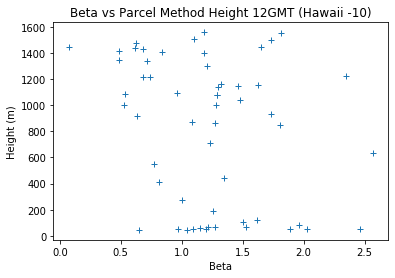

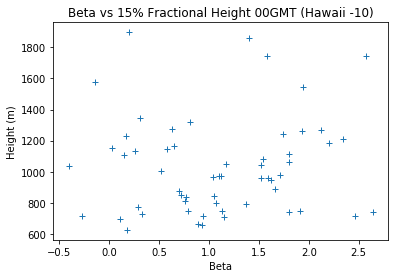

r= nan


In [30]:
pbl_heights_ri, turbulence_exponents_ri = get_radiosonde_betas(pbl_height_ri_dict, time_betahat_dict, gmt=12)

plt.figure()
plt.plot(turbulence_exponents_ri, pbl_heights_ri, '+')
print('r=', round(np.corrcoef(turbulence_exponents_ri, pbl_heights_ri)[0,1],2))
# plt.xlim([0, 2.4])
# plt.ylim([32000, 38000])
plt.title('Beta vs Ri-Method Height 12GMT (Hawaii -10)')
plt.xlabel('Beta')
plt.ylabel('Height (m)')
plt.show()

pbl_heights_holz, turbulence_exponents_holz = get_radiosonde_betas(pbl_height_holzworth_dict, time_betahat_dict, gmt=12)

plt.figure()
plt.plot(turbulence_exponents_holz, pbl_heights_holz, '+')
print('r=', round(np.corrcoef(turbulence_exponents_holz, pbl_heights_holz)[0,1],2))
# plt.xlim([0, 2.4])
# plt.ylim([32000, 38000])
plt.title('Beta vs Parcel Method Height 12GMT (Hawaii -10)')
plt.xlabel('Beta')
plt.ylabel('Height (m)')
plt.show()

frac_heights, turbulence_exponents_hfs = get_radiosonde_betas(frac_height_15_dict, time_betahat_dict, gmt=0)

plt.figure()
plt.plot(turbulence_exponents_hfs, frac_heights, '+')
# plt.xlim([0, 2.4])
# plt.ylim([500, 2200])
plt.title('Beta vs 15% Fractional Height 00GMT (Hawaii -10)')
plt.xlabel('Beta')
plt.ylabel('Height (m)')
plt.show()
print('r=', np.corrcoef(turbulence_exponents_hfs, frac_heights)[0,1])
